In [ ]:
"""
Load:
  x_a_init.txt
Save:
  x_b.txt
  x_a.txt
"""
import numpy as np
from scipy.integrate import ode
import lorenz96
import matplotlib.pyplot as plt
from settings import *
import matplotlib.pyplot as plt

In [ ]:
def locallization(B):
    W = np.zeros([40,40])
    L=10
    
    for i in range(40):
        for j in range(40):
            d_i = np.mod(np.abs(i+40-j),40)
            d_j = np.mod(np.abs(j+40-i),40)
            d = np.min([d_i,d_j])
            W[i,j] = np.exp(-1*d**2/2/L**2)

    return np.multiply(W,B)

In [ ]:
test_matrix = np.ones([40,40])
#print(locallization(test_matrix))


fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
ax.set_title('input matrix')
plt.imshow(HPH)
ax.set_aspect('auto')
cax = fig.add_axes([0.26, 0.1, 0.26, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

ax2 = fig.add_subplot(122)
ax2.set_title('output matrix')
plt.imshow(np.reshape(locallization(HPH),[40,40])-B)
ax2.set_aspect('auto')

cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()
#plt.savefig('locallization_example.png', dpi=200)

In [ ]:
nT = 800
nk = 20
#set random seed
np.random.seed(201910)

#load true value
x_t_save = np.genfromtxt('x_t.txt')

# load initial condition
x_a_init = np.genfromtxt('x_a_init.txt')
analysis_error = 25.e-2
#load background error covariance matrix
B = np.genfromtxt('B.txt')

np.random.seed(20191031)
# create observations

observation_error = 25.e-2
y_o_save = np.zeros([nT+1, N])
y_o_save = x_t_save + observation_error * np.random.randn(nT+1, N)

# initial x_b: no values at the initial time (assign NaN)
x_b_save = np.array([x_a_init])

# initial x_a: from x_a_ens_init

x_a_save = np.array([x_a_init])
print("x_a_save shape = ",x_a_save.shape)

tt = 0
R = 0.25 * np.identity(40) #observation error covariance

B_temp_2 = B.copy()
B_a = np.reshape(B_temp_2,[40,40,1])
B_f = np.reshape(B_temp_2,[40,40,1])
H = np.identity(40)

while tt <= nT:
    ttf = tt + 1
    Ta = tt  * dT  # forecast start time(DA time)
    Tf = ttf * dT  # forecast end time
    print('Cycle =', tt, ', Ta =', round(Ta, 10), ', Tf =', round(Tf, 10))
    
    # background
    if tt ==0:
        B = B.copy()
        K_i = np.dot(B, np.dot(H, np.linalg.inv(np.dot(H, np.dot(B,H))+R)))
        K = np.reshape(K_i, [1,40,40])

    else:
        k_i = np.split(K,ttf)[tt]
    for e in range(nk):
        #--------------
        # analysis step
        #--------------
        x_b = x_b_save[tt].transpose()
        # observation
        y_o = y_o_save[tt].transpose()
        #perturb observation
        np.random.seed(20191130+e)
        y_o_k = y_o + observation_error * np.random.randn(N)
        
        # innovation
        y_b = np.dot(H, x_b)
        d = y_o_k - y_b
        x_a = x_b + np.dot(K_i,d)
        if e == 0:
            x_a_k_save = np.reshape(x_a.transpose(),[1,40])
        else:
            #print()
            x_a_k_save = np.vstack([x_a_k_save, np.reshape(x_a,[1,40])])
        #--------------
        # forecast step
        #--------------
        np.random.seed(20181130+e+2*tt)
        #print(x_a_k_save[tt].shape)
        solver = ode(lorenz96.f).set_integrator('dopri5')
        solver.set_initial_value(x_a.transpose() + 0.12 * np.random.randn(N), Ta).set_f_params(F)
        solver.integrate(Tf)
        if e == 0:
            x_b_k_save = np.array([solver.y])
        else:
            x_b_k_save = np.vstack([x_b_k_save, [solver.y]])

    x_a_k_mean = np.mean(x_a_k_save, axis = 0)
    x_b_k_mean = np.mean(x_b_k_save, axis = 0)
    x_b_save = np.vstack([x_b_save,x_b_k_mean])
    x_a_save = np.vstack([x_a_save, x_a_k_mean])
    #do the poll
    

    PH = np.cov(x_b_k_save,rowvar = False)
    HPH = np.cov(x_b_k_save,rowvar = False)
    
    #print(np.trace(PH))
    K_ip1 = np.dot(locallization(PH), np.linalg.inv(locallization(HPH)+R))
    K = np.concatenate((K, np.reshape(K_ip1,[1,40,40])), axis =0)
    print(np.trace(PH))
    tt += 1

#save background and analysis data

x_b_save = x_b_save[0:801][:]
x_a_save = x_a_save[1:802][:]

np.savetxt('x_b_k20_l10.txt', x_b_save)
np.savetxt('x_a_k20_l10.txt', x_a_save)

x_a_save shape =  (1, 40)
Cycle = 0 , Ta = 0.0 , Tf = 0.05
0.8012051589056198
Cycle = 1 , Ta = 0.05 , Tf = 0.1
0.817534972051166
Cycle = 2 , Ta = 0.1 , Tf = 0.15
0.7282308709364052
Cycle = 3 , Ta = 0.15 , Tf = 0.2
0.7589486410309458
Cycle = 4 , Ta = 0.2 , Tf = 0.25
0.7809594483919418
Cycle = 5 , Ta = 0.25 , Tf = 0.3
0.6878603489622575
Cycle = 6 , Ta = 0.3 , Tf = 0.35
0.7440677332642844
Cycle = 7 , Ta = 0.35 , Tf = 0.4
0.6700335562796136
Cycle = 8 , Ta = 0.4 , Tf = 0.45
0.7341313479544895
Cycle = 9 , Ta = 0.45 , Tf = 0.5
0.7349282042716656
Cycle = 10 , Ta = 0.5 , Tf = 0.55
0.7048088520203429
Cycle = 11 , Ta = 0.55 , Tf = 0.6
0.7310818766593449
Cycle = 12 , Ta = 0.6 , Tf = 0.65
0.7534136460470457
Cycle = 13 , Ta = 0.65 , Tf = 0.7
0.7477623004524643
Cycle = 14 , Ta = 0.7 , Tf = 0.75
0.6811906937682648
Cycle = 15 , Ta = 0.75 , Tf = 0.8
0.7236438621666808
Cycle = 16 , Ta = 0.8 , Tf = 0.85
0.75895604378061
Cycle = 17 , Ta = 0.85 , Tf = 0.9
0.7103623323549326
Cycle = 18 , Ta = 0.9 , Tf = 0.95

0.7374331195190034
Cycle = 156 , Ta = 7.8 , Tf = 7.85
0.7518741129589057
Cycle = 157 , Ta = 7.85 , Tf = 7.9
0.7138725428975685
Cycle = 158 , Ta = 7.9 , Tf = 7.95
0.7052945692538284
Cycle = 159 , Ta = 7.95 , Tf = 8.0
0.698074428001478
Cycle = 160 , Ta = 8.0 , Tf = 8.05
0.7165869829500658
Cycle = 161 , Ta = 8.05 , Tf = 8.1
0.7722103210421339
Cycle = 162 , Ta = 8.1 , Tf = 8.15
0.7586728039271194
Cycle = 163 , Ta = 8.15 , Tf = 8.2
0.6715815315663274
Cycle = 164 , Ta = 8.2 , Tf = 8.25
0.7613693067755118
Cycle = 165 , Ta = 8.25 , Tf = 8.3
0.7823943921220633
Cycle = 166 , Ta = 8.3 , Tf = 8.35
0.773562941500388
Cycle = 167 , Ta = 8.35 , Tf = 8.4
0.7702283443839243
Cycle = 168 , Ta = 8.4 , Tf = 8.45
0.731328662709635
Cycle = 169 , Ta = 8.45 , Tf = 8.5
0.7200769193590902
Cycle = 170 , Ta = 8.5 , Tf = 8.55
0.7143931275514126
Cycle = 171 , Ta = 8.55 , Tf = 8.6
0.8180717896144749
Cycle = 172 , Ta = 8.6 , Tf = 8.65
0.7387155739779592
Cycle = 173 , Ta = 8.65 , Tf = 8.7
0.776755225279926
Cycle = 174 ,

0.7817875374009755
Cycle = 307 , Ta = 15.35 , Tf = 15.4
0.7666545513716738
Cycle = 308 , Ta = 15.4 , Tf = 15.45
0.7109936715059015
Cycle = 309 , Ta = 15.45 , Tf = 15.5
0.6935400944267693
Cycle = 310 , Ta = 15.5 , Tf = 15.55
0.7569093412147141
Cycle = 311 , Ta = 15.55 , Tf = 15.6
0.7247070124475574
Cycle = 312 , Ta = 15.6 , Tf = 15.65
0.724810658825279
Cycle = 313 , Ta = 15.65 , Tf = 15.7
0.7456752613344442
Cycle = 314 , Ta = 15.7 , Tf = 15.75
0.6890822892302825
Cycle = 315 , Ta = 15.75 , Tf = 15.8
0.7141477840611505
Cycle = 316 , Ta = 15.8 , Tf = 15.85
0.7203115060024122
Cycle = 317 , Ta = 15.85 , Tf = 15.9
0.6962263436017718
Cycle = 318 , Ta = 15.9 , Tf = 15.95
0.6623177529444121
Cycle = 319 , Ta = 15.95 , Tf = 16.0
0.7064152644510517
Cycle = 320 , Ta = 16.0 , Tf = 16.05
0.7694544863451296
Cycle = 321 , Ta = 16.05 , Tf = 16.1
0.7506659502471293
Cycle = 322 , Ta = 16.1 , Tf = 16.15
0.7517340437595508
Cycle = 323 , Ta = 16.15 , Tf = 16.2
0.780716699530179
Cycle = 324 , Ta = 16.2 , Tf = 

bias =  0.03517559801338772
rmse =  0.24149158713228996


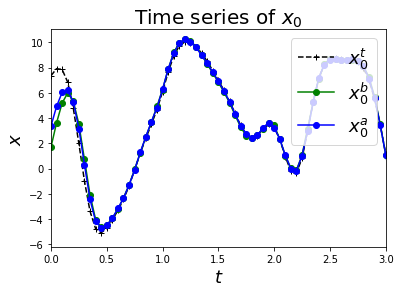

bias =  -0.043732273070655976
rmse =  0.22959646317815724


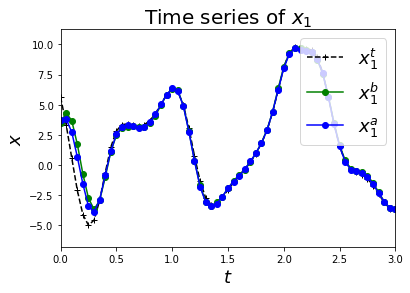

bias =  0.10613089806785103
rmse =  0.2626458652009721


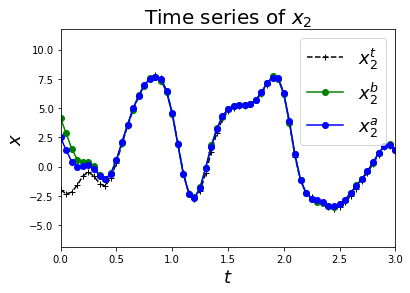

bias =  -0.027094789376244176
rmse =  0.1455327824041453


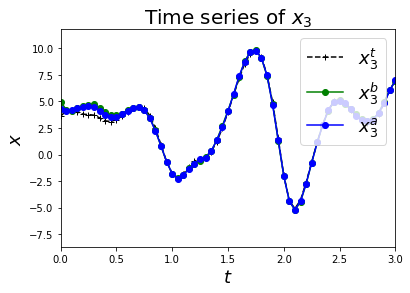

bias =  -0.08464066773621469
rmse =  0.14812011979862555


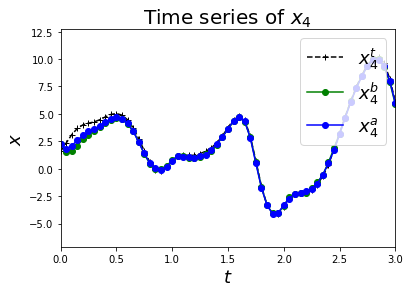

bias =  0.0948986636958918
rmse =  0.1747784527863166


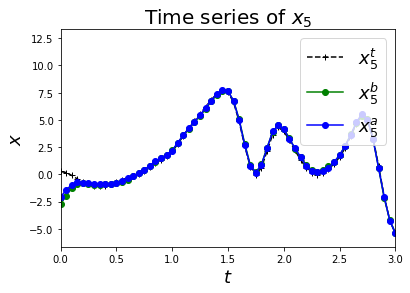

bias =  0.04806044169039435
rmse =  0.17751368169430662


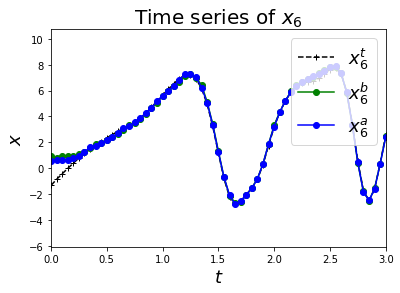

bias =  0.0026779449663806966
rmse =  0.13559373096238136


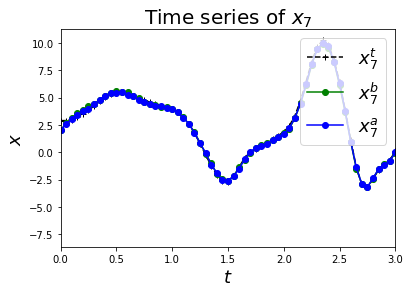

bias =  0.11697244507739574
rmse =  0.21598195416367416


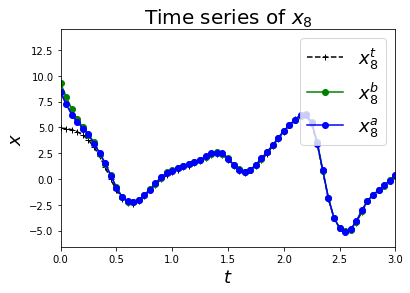

bias =  0.040715936734965694
rmse =  0.14186770323730075


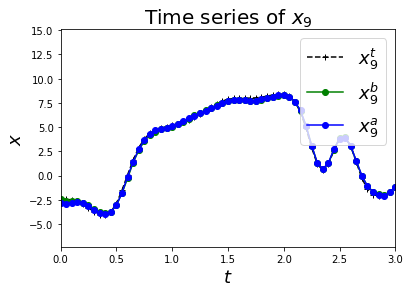

bias =  0.011776625241683462
rmse =  0.19959574294842655


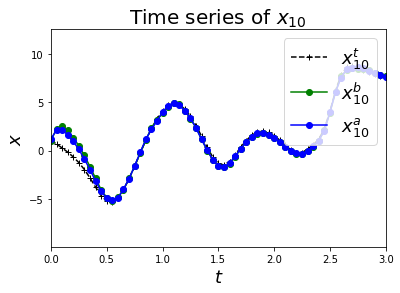

bias =  -0.015245501896916128
rmse =  0.4138049032300139


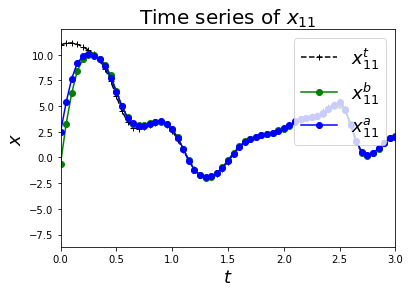

bias =  -0.06651874046506574
rmse =  0.19985130227315892


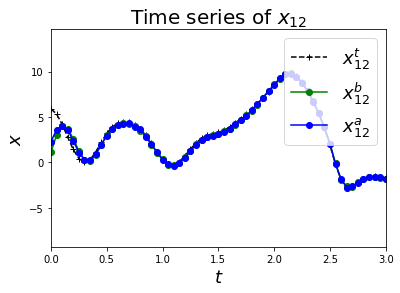

bias =  0.009688482285343926
rmse =  0.3000132414977348


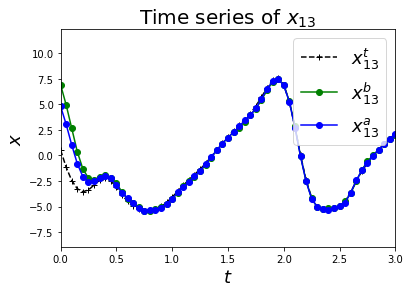

bias =  0.011821888562189518
rmse =  0.1831544590608915


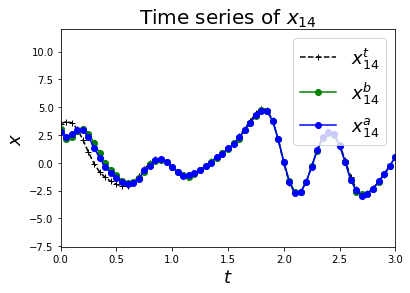

bias =  -0.07103715714886284
rmse =  0.4270860965450266


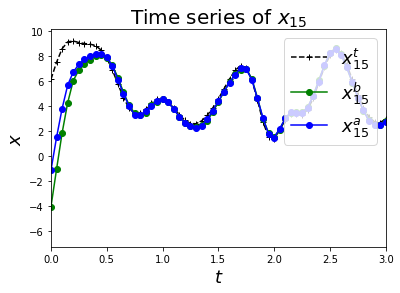

bias =  0.04336049374911939
rmse =  0.33683648109012737


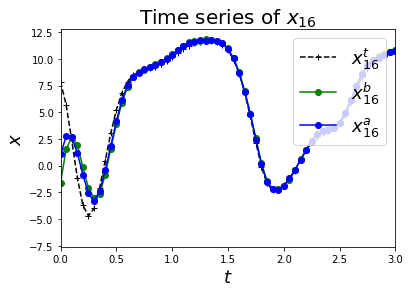

bias =  0.08595334419090195
rmse =  0.2300394122400832


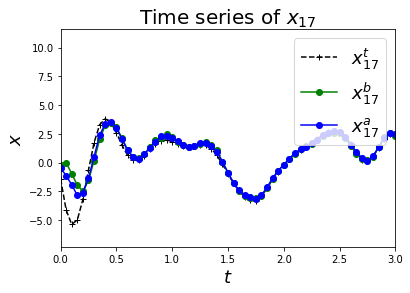

bias =  -0.07017211854978703
rmse =  0.1951633448956203


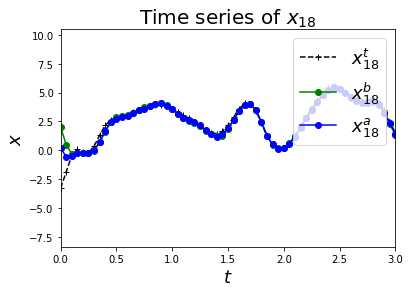

bias =  -0.0035132813194387966
rmse =  0.3313953650821533


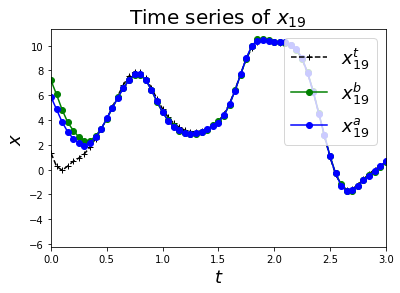

bias =  -0.02621120176369147
rmse =  0.2058231417056539


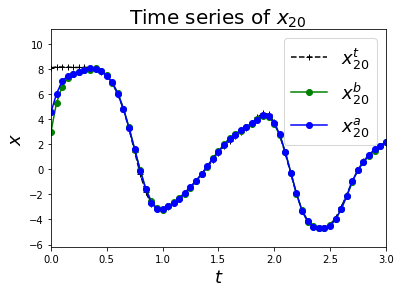

bias =  -0.04325881476260036
rmse =  0.19905358954471364


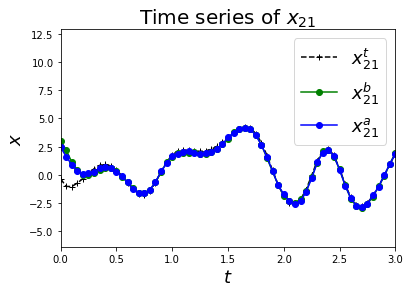

bias =  -0.000727751892015746
rmse =  0.30484804155863643


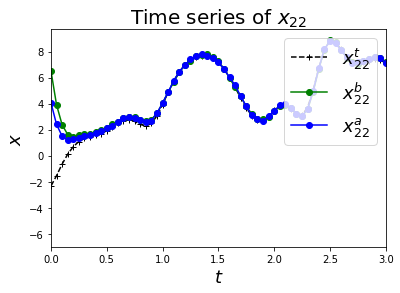

bias =  0.0077636938352811215
rmse =  0.18533687347632197


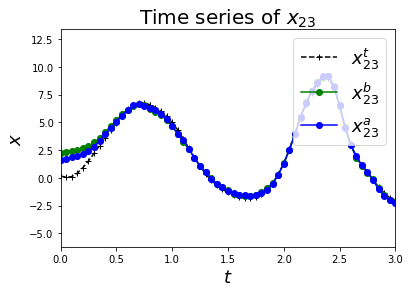

bias =  0.04266942730789767
rmse =  0.14399387716580725


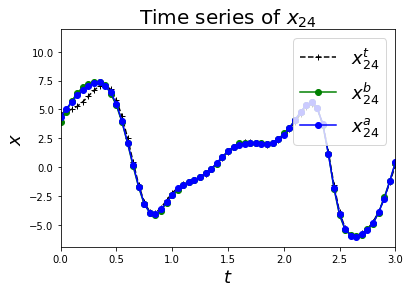

bias =  -0.0054345663996880735
rmse =  0.21661805437274045


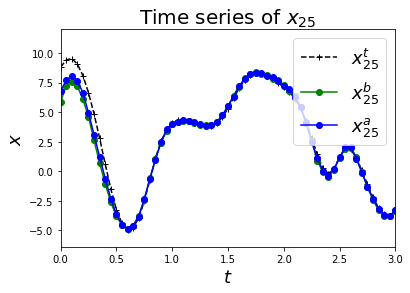

bias =  -0.03564566595916336
rmse =  0.1402368350841035


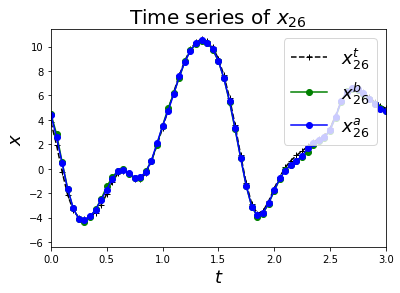

bias =  -0.033195930393077513
rmse =  0.1511416038809175


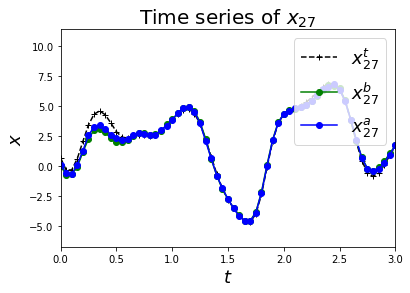

bias =  0.02429644188180319
rmse =  0.14402508234571923


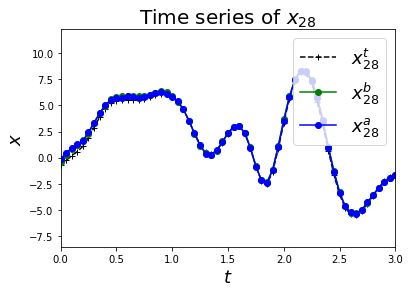

bias =  -0.003741283818670131
rmse =  0.22959861197111903


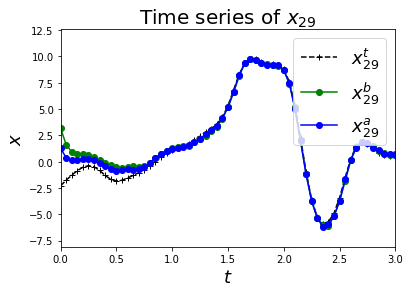

bias =  0.10181714492667325
rmse =  0.4697097821888565


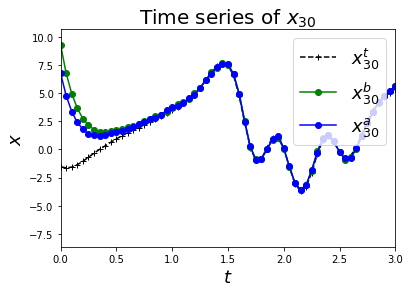

bias =  -0.021383116570669488
rmse =  0.3456081773260534


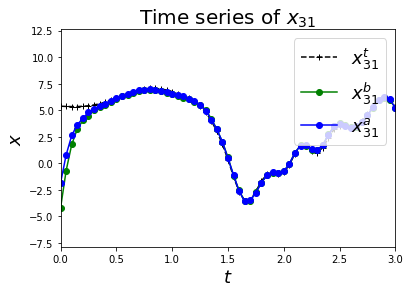

bias =  -0.010813785810557747
rmse =  0.24227331374460268


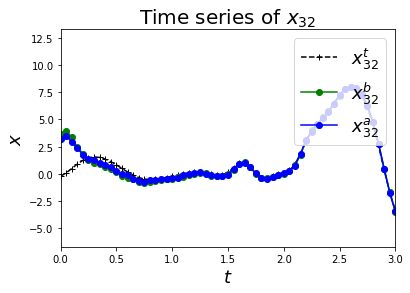

bias =  -0.03245033364099154
rmse =  0.12963933712599618


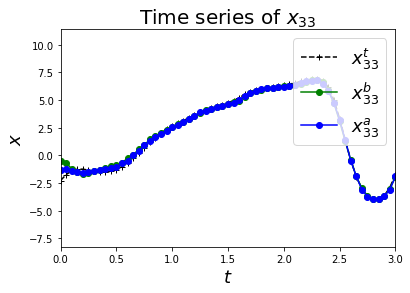

bias =  0.006917601107896682
rmse =  0.2250286034693899


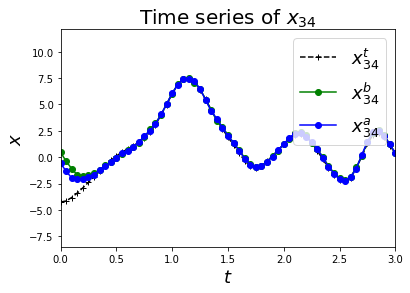

bias =  0.013337847991664875
rmse =  0.2503189744262515


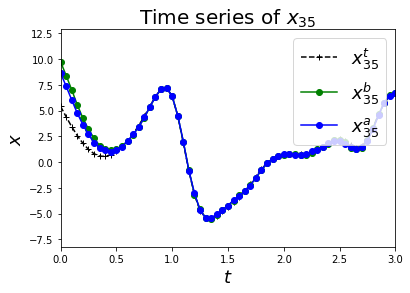

bias =  0.05422392054865246
rmse =  0.14118385599206773


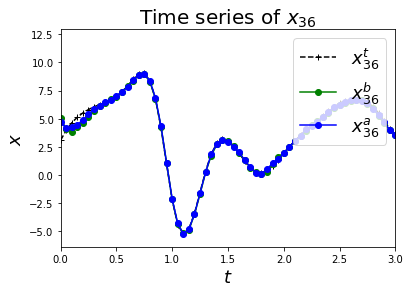

bias =  -0.04570822271378165
rmse =  0.15438698714801966


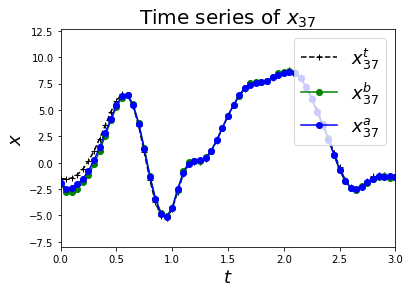

bias =  -0.0001368144870242213
rmse =  0.11609171775824506


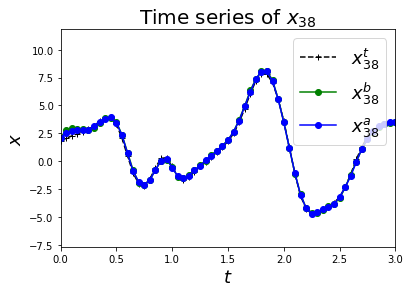

bias =  0.0590173707489878
rmse =  0.23579954980444062


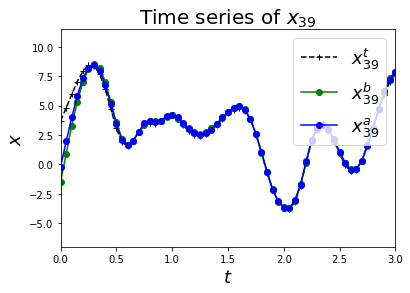

bias= 0.00691535482123114
rmse= 0.15772007067021132


In [415]:
bias_v = []
rmse_v = []

for i in range(N):
    pt = i
    plt.figure()
    #print(x_a_save[:,pt-1])
    #print(x_b_save[:,pt-1])
    
    plt.plot(np.arange(nT+1) * dT, x_t_save[:,pt-1], 'k+--', label=r'$x^t_{' + str(pt) + '}$')
    plt.plot(np.arange(nT+1) * dT, x_b_save[:,pt-1], 'go-' , label=r'$x^b_{' + str(pt) + '}$')
    plt.plot(np.arange(nT+1) * dT, x_a_save[:,pt-1], 'bo-' , label=r'$x^a_{' + str(pt) + '}$')
    bias_i = (x_a_save[:,pt-1]-x_t_save[:,pt-1]).mean()
    print("bias = ", bias_i)
    rmse_i = np.std(x_a_save[:,pt-1]-x_t_save[:,pt-1])
    print("rmse = ", rmse_i)
    bias_v.append(bias_i)
    rmse_v.append(rmse_i)
    
    plt.xlabel(r'$t$', size=18)
    plt.ylabel(r'$x$', size=18)
    plt.xlim(0,3)
    plt.title(r'Time series of $x_{' + str(pt) + '}$', size=20)
    plt.legend(loc='upper right', numpoints=1, prop={'size':18})
    #plt.savefig('timeseries.png', dpi=200)
    plt.show()
    plt.close()
print("bias=",np.mean(bias_v))
print("rmse=",np.mean(rmse))

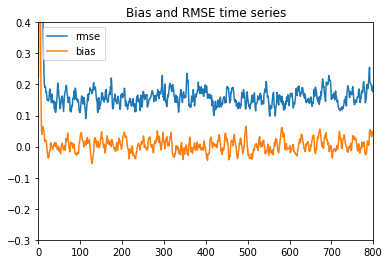

rmse= 0.15772007067021132
bias= 0.003861134539443884


In [414]:
analysis_error = x_b_save-x_t_save
bias_t = []
rmse_t = []
for i in range(nT):
    
    bias_i = analysis_error[i][:].mean()
    rmse_i = np.std(analysis_error[i][:])
    bias_t = np.append(bias_t, bias_i)
    rmse_t = np.append(rmse_t, rmse_i)


plt.plot(rmse_t, label ="rmse" )
plt.plot(bias_t, label = "bias")
plt.ylim(-0.3,0.4)
plt.xlim(0,800)
plt.legend(loc="upper left")
plt.title("Bias and RMSE time series")
plt.show()
rmse = rmse_t[30:800].mean()
bias = bias_t[30:800].mean()
print("rmse=",rmse)
print("bias=",bias)

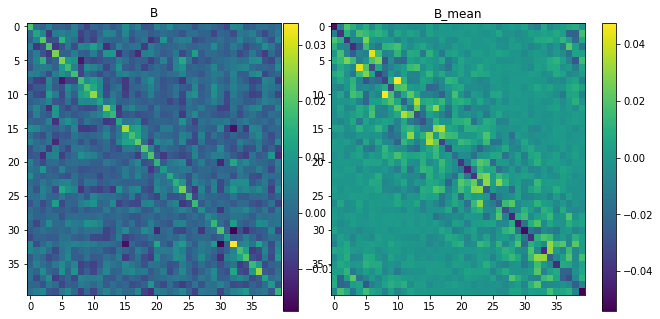

In [409]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
ax.set_title('B')
plt.imshow(HPH)
ax.set_aspect('auto')
cax = fig.add_axes([0.26, 0.08, 0.26, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

ax2 = fig.add_subplot(122)
ax2.set_title('B_mean')
plt.imshow(np.reshape(k_i,[40,40])-B)
ax2.set_aspect('auto')

cax = fig.add_axes([0.26, 0.08, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

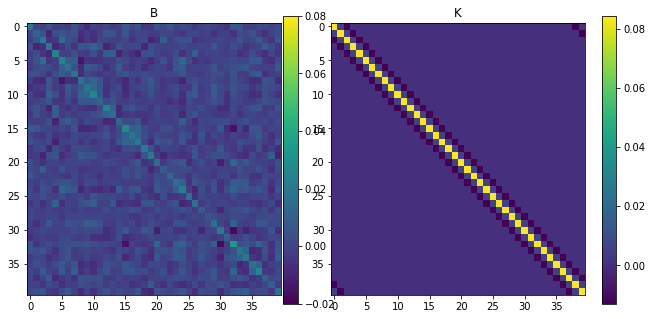

In [410]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
ax.set_title('B')
plt.imshow(HPH,vmin=-0.02,vmax=0.08)
ax.set_aspect('auto')
cax = fig.add_axes([0.26, 0.1, 0.26, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

ax2 = fig.add_subplot(122)
ax2.set_title('K')
plt.imshow(B)
ax2.set_aspect('auto')

cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

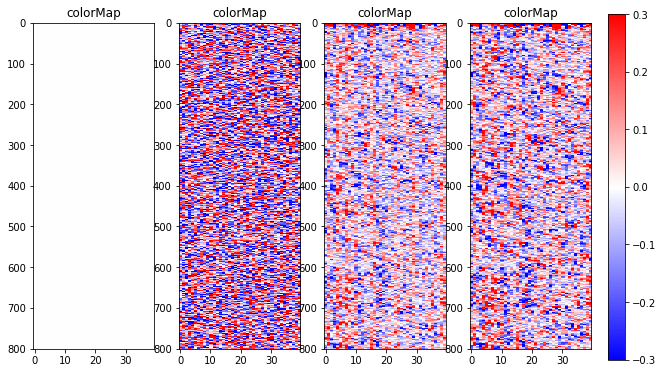

In [411]:
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(141)
ax.set_title('colorMap')
plt.imshow(x_t_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax.set_aspect('auto')

ax2 = fig.add_subplot(142)
ax2.set_title('colorMap')
plt.imshow(y_o_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax2.set_aspect('auto')


ax3 = fig.add_subplot(143)
ax3.set_title('colorMap')
plt.imshow(x_a_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax3.set_aspect('auto')


ax4 = fig.add_subplot(144)
ax4.set_title('colorMap')
plt.imshow(x_b_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax4.set_aspect('auto')


cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

In [387]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(xlim=(0, 40), ylim=(0, 40))

ax.set_title('B')
ax.set_aspect('auto')

#line, = ax.plot([], [], lw=2)
a = np.random.random((40,40))
im = plt.imshow(a,interpolation='none', vmin=-0.02, vmax =0.06)
# initialization function: plot the background of each frame
def init():
    im.set_data(np.random.random((40,40)))
           
    cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical')
    
    return [im]

# animation function.  This is called sequentially
def animate(i):

    a = np.reshape(np.split(K,ttf+1)[i], [40,40])
    im.set_array(a)

    return [im]

/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


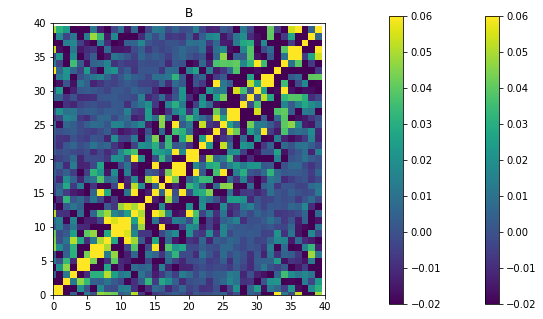

In [388]:
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=200, interval=10, blit=True)
anim.save('basic_animation.mp4', fps=12, extra_args=['-vcodec', 'libx264'])
plt.show()